In [1]:
import cv2
import os
import shutil 
import math
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

# Data Preparation

In [2]:
def FormatDataset(dataset_src, dataset_dest, classes):
    # Making a Copy of Dataset
    new_cropped_dest = [os.path.join(dataset_dest, cls)  for cls in classes]
    cropped_src = [ dataset_src + "/im_" + cls + "/im_" + cls  for cls in classes ]
    
    for dir_ in new_cropped_dest:
        os.makedirs(dir_)
    
    # Formating Cropped Images
    # Formating Cropped Images
    for (src,new_dest) in zip(cropped_src, new_cropped_dest):
        for file in os.listdir(src):
            filename, file_ext = os.path.splitext(file);
            if file_ext == '.bmp':
                img_des = os.path.join(new_dest, filename + '.jpg')
                img = cv2.imread(os.path.join(src, file))
                img = cv2.resize(img, (256,256))
                img = cv2.cvtColor(images[i],cv2.COLOR_BGR2RGB)
                img = cv2.filter2D(img, -1, kernel_sharpening)
                #img = cv2.blur(img, (2, 2))
                cv2.imwrite(img_des ,img)

# Source Location for Dataset
src = 'archive';
# Destination Location for Dataset
dest = './CervicalCancer';
# Image Classes
classes = ["Dyskeratotic","Koilocytotic","Metaplastic","Parabasal","Superficial-Intermediate"];
# Formatting Dataset
FormatDataset(src, dest, classes);

NameError: name 'images' is not defined

# Data Visulisation

In [ ]:
Dyskeratotic_img = cv2.imread(r"CervicalCancer\Dyskeratotic\001.jpg")
Koilocytotic_ing = cv2.imread(r"CervicalCancer\Koilocytotic\001.jpg")
Metaplastic_img = cv2.imread(r"CervicalCancer\Metaplastic\001.jpg")
Parabasal = cv2.imread(r"CervicalCancer\Parabasal\001.jpg")
Superficial = cv2.imread(r"CervicalCancer\Superficial-Intermediate\001.jpg")

In [4]:
images = [Dyskeratotic_img,Koilocytotic_ing,Metaplastic_img,Parabasal,Superficial]


### RGB 

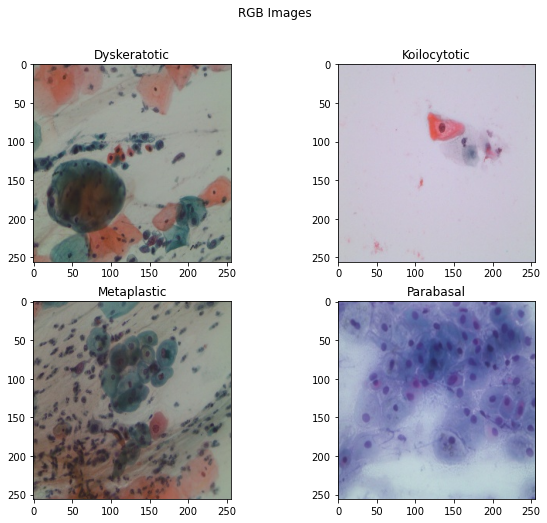

In [5]:
plt.figure(figsize=(10,8))
for i in range(4):
    plt.subplot(2,2,i+1)
    img = cv2.cvtColor(images[i],cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(classes[i])
plt.suptitle("RGB Images")
plt.show()

### Gray Scaled

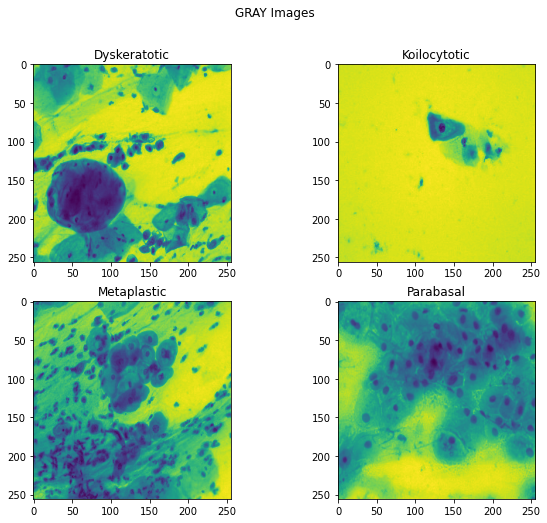

In [6]:
plt.figure(figsize=(10,8))
for i in range(4):
    plt.subplot(2,2,i+1)
    
    img = cv2.cvtColor(images[i],cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    plt.imshow(img)
    plt.title(classes[i])
plt.suptitle("GRAY Images")
plt.show()

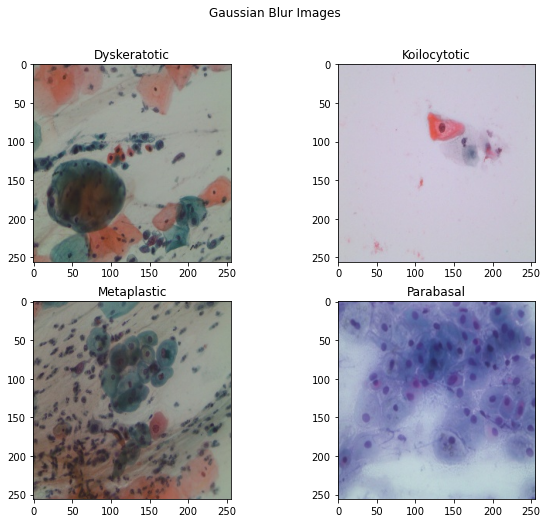

In [7]:
plt.figure(figsize=(10,8))
for i in range(4):
    plt.subplot(2,2,i+1)
    
    img = cv2.cvtColor(images[i],cv2.COLOR_BGR2RGB)
    blur = cv2.GaussianBlur(img, (5,5), 0)
    
    plt.imshow(img)
    plt.title(classes[i])
plt.suptitle("Gaussian Blur Images")
plt.show()

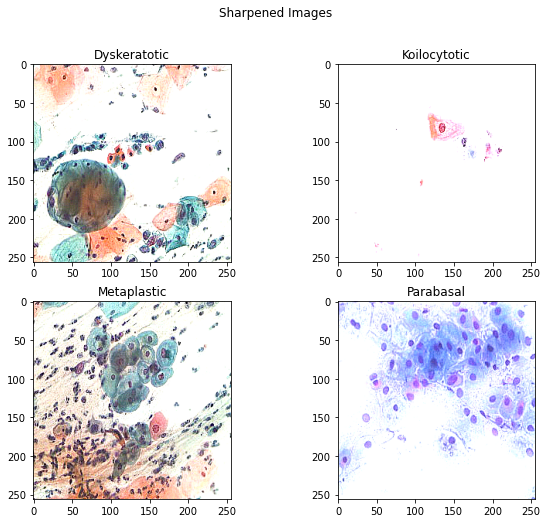

In [8]:
kernel_sharpening = np.array([[-1,-1,-1], 
                              [-1,10,-1], 
                              [-1,-1,-1]])


plt.figure(figsize=(10,8))
for i in range(4):
    plt.subplot(2,2,i+1)
    
    img = cv2.cvtColor(images[i],cv2.COLOR_BGR2RGB)
    img = cv2.filter2D(img, -1, kernel_sharpening)
    
    plt.imshow(img)
    plt.title(classes[i])
plt.suptitle("Sharpened Images")
plt.show()

In [3]:
datadir = "CervicalCancer/"
target_shape = [256,256,3]
height,width,depth = target_shape

train_batch_size = 6
val_batch_size = 4


In [10]:
# Data with  preprocessing

img_gen_train = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,
                                                                   rescale=1/255.,
                                                                   validation_split=0.2)
img_gen_val = tf.keras.preprocessing.image.ImageDataGenerator( rescale=1/255.,
                                                                   validation_split=0.2)


train_data = img_gen_train.flow_from_directory(datadir,
                                        target_size=(target_shape[0], target_shape[1]),
                                        color_mode='rgb',
                                        class_mode='categorical',
                                        batch_size=train_batch_size,subset='training')

val_data = img_gen_val.flow_from_directory(datadir,
                        target_size=(target_shape[0], target_shape[1]),
                        color_mode='rgb',
                        class_mode='categorical',
                        batch_size=val_batch_size,subset='validation')


Found 775 images belonging to 5 classes.
Found 191 images belonging to 5 classes.


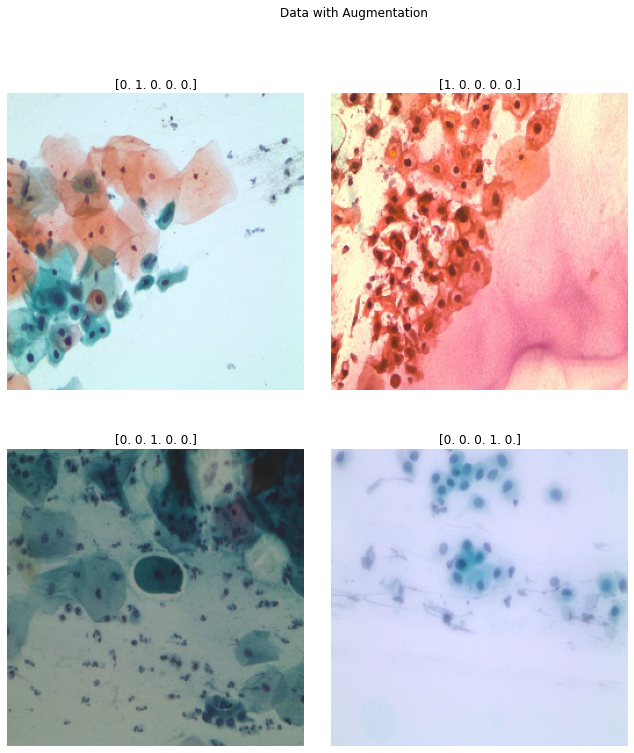

In [11]:
nrows = 2
ncols = 2

fig, axes = plt.subplots(nrows=nrows,ncols = ncols)
fig.set_size_inches(10,12)

temp_img = train_data.next()
for i in range(nrows*ncols):
    image = temp_img[0][i]
    
    plt.subplot(nrows,ncols,i+1)
    plt.imshow(image)
    plt.title(temp_img[1][i])
    plt.axis('off')
plt.subplots_adjust(left = 0,wspace = 0,hspace = 0.2)
plt.suptitle("Data with Augmentation")
plt.show()

# Model comparative analysis

### InceptionV3

In [12]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

In [13]:
# Defining model 
# We will be training from scratch
model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=target_shape)

model_InceptionV3 = tf.keras.models.Sequential()
model_InceptionV3.add(model)
model_InceptionV3.add(tf.keras.layers.Flatten())
model_InceptionV3.add(tf.keras.layers.BatchNormalization())
model_InceptionV3.add(tf.keras.layers.Dense(256, activation='relu'))
model_InceptionV3.add(tf.keras.layers.Dropout(0.5))

model_InceptionV3.add(tf.keras.layers.Dense(128, activation='relu'))

model_InceptionV3.add(tf.keras.layers.Dense(5, activation='softmax'))

model_InceptionV3.layers[0].trainable=False

In [14]:
model_InceptionV3.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy",precision,recall])

history_model_InceptionV3 = model_InceptionV3.fit(train_data,batch_size=train_batch_size,validation_data=val_data,epochs=50)

Epoch 1/50
130/130 [==============================] - 29s 139ms/step - loss: 9.9271 - accuracy: 0.5252 - precision: 0.5267 - recall: 0.5213 - val_loss: 7.6995 - val_accuracy: 0.6492 - val_precision: 0.6526 - val_recall: 0.6492
Epoch 2/50
130/130 [==============================] - 13s 104ms/step - loss: 7.0799 - accuracy: 0.6529 - precision: 0.6537 - recall: 0.6529 - val_loss: 6.6707 - val_accuracy: 0.7277 - val_precision: 0.7277 - val_recall: 0.7277
Epoch 3/50
130/130 [==============================] - 14s 105ms/step - loss: 5.5960 - accuracy: 0.7084 - precision: 0.7089 - recall: 0.7071 - val_loss: 6.1253 - val_accuracy: 0.7435 - val_precision: 0.7435 - val_recall: 0.7435
Epoch 4/50
130/130 [==============================] - 14s 105ms/step - loss: 5.7150 - accuracy: 0.7252 - precision: 0.7261 - recall: 0.7252 - val_loss: 4.7324 - val_accuracy: 0.7173 - val_precision: 0.7173 - val_recall: 0.7173
Epoch 5/50
130/130 [==============================] - 13s 96ms/step - loss: 3.5636 - accurac

130/130 [==============================] - 12s 96ms/step - loss: 0.4977 - accuracy: 0.9187 - precision: 0.9233 - recall: 0.9161 - val_loss: 1.4410 - val_accuracy: 0.7958 - val_precision: 0.8011 - val_recall: 0.7801
Epoch 38/50
130/130 [==============================] - 13s 96ms/step - loss: 0.3574 - accuracy: 0.9239 - precision: 0.9249 - recall: 0.9213 - val_loss: 2.0720 - val_accuracy: 0.7487 - val_precision: 0.7765 - val_recall: 0.7277
Epoch 39/50
130/130 [==============================] - 13s 96ms/step - loss: 0.4659 - accuracy: 0.9174 - precision: 0.9206 - recall: 0.9123 - val_loss: 2.4236 - val_accuracy: 0.7225 - val_precision: 0.7389 - val_recall: 0.6963
Epoch 40/50
130/130 [==============================] - 13s 96ms/step - loss: 0.5013 - accuracy: 0.9174 - precision: 0.9206 - recall: 0.9123 - val_loss: 1.2348 - val_accuracy: 0.7487 - val_precision: 0.7955 - val_recall: 0.7330
Epoch 41/50
130/130 [==============================] - 13s 96ms/step - loss: 0.4739 - accuracy: 0.9045 -

### ResNet50

In [15]:
model = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=target_shape)
model_ResNet50 = tf.keras.models.Sequential()
model_ResNet50.add(model)
model_ResNet50.add(tf.keras.layers.Flatten())
model_ResNet50.add(tf.keras.layers.BatchNormalization())
model_ResNet50.add(tf.keras.layers.Dense(256, activation='relu'))
model_ResNet50.add(tf.keras.layers.Dropout(0.5))

model_ResNet50.add(tf.keras.layers.Dense(128, activation='relu'))

model_ResNet50.add(tf.keras.layers.Dense(5, activation='softmax'))

model_ResNet50.layers[0].trainable=False

In [16]:
model_ResNet50.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy",precision, recall])

history_model_resnet50 = model_ResNet50.fit(train_data,batch_size=train_batch_size,validation_data=val_data,epochs=50)

Epoch 1/50
130/130 [==============================] - 22s 141ms/step - loss: 7.4607 - accuracy: 0.3535 - precision: 0.4330 - recall: 0.4151 - val_loss: 3.5280 - val_accuracy: 0.2670 - val_precision: 0.2703 - val_recall: 0.2618: 7.8519 - accuracy: 0.3395 - precision: 0.506 - ETA: 6s - loss: 8.5916 - accuracy: 0.3245 - precision: 0 - ETA: 4s - loss: 7.9253 - accuracy
Epoch 2/50
130/130 [==============================] - 16s 121ms/step - loss: 3.6422 - accuracy: 0.3781 - precision: 0.3946 - recall: 0.3574 - val_loss: 1.9591 - val_accuracy: 0.3246 - val_precision: 0.2957 - val_recall: 0.1780 - accuracy: 0.4028 - ETA: 0s - loss: 3.6733 - accuracy: 0.3828 - precision: 0.4015 - reca
Epoch 3/50
130/130 [==============================] - 16s 126ms/step - loss: 2.4318 - accuracy: 0.3303 - precision: 0.3701 - recall: 0.2813 - val_loss: 1.4764 - val_accuracy: 0.3822 - val_precision: 0.5000 - val_recall: 0.0419
Epoch 4/50
130/130 [==============================] - 17s 129ms/step - loss: 1.7613 - ac

130/130 [==============================] - 18s 138ms/step - loss: 1.3609 - accuracy: 0.4297 - precision: 0.6848 - recall: 0.2271 - val_loss: 1.4889 - val_accuracy: 0.3560 - val_precision: 0.4426 - val_recall: 0.1414: 0.4343 - precisi - ETA: 0s - loss: 1.3508 - accuracy: 0.4299 - precision: 0.6850 - recall: 0.2
Epoch 27/50
130/130 [==============================] - 16s 122ms/step - loss: 1.3234 - accuracy: 0.4297 - precision: 0.7027 - recall: 0.2348 - val_loss: 1.4956 - val_accuracy: 0.3298 - val_precision: 0.4091 - val_recall: 0.0942  - ETA: 7s - loss: 1.3466 - accuracy: 0.4414 -  - ETA: 4s - loss: 1.3394 - accuracy: 0.4340 - precision: 0.6872 - recall: 0.256 - ETA: 4s - loss: 1.3375 - accuracy: 0.4367 - precision: 0.6888 - recall:  - ETA: 3s - loss: 1.3232 - accuracy: 0.4425 
Epoch 28/50
130/130 [==============================] - 20s 153ms/step - loss: 1.2749 - accuracy: 0.4465 - precision: 0.7128 - recall: 0.2594 - val_loss: 1.4771 - val_accuracy: 0.3665 - val_precision: 0.4390 - val

### Custom Model

In [24]:
# Data with  preprocessing
target_shape = [64,64,3]
height,width,depth = target_shape
img_gen_train = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.,
                                                                   validation_split=0.2)
img_gen_val = tf.keras.preprocessing.image.ImageDataGenerator( rescale=1/255.,
                                                                   validation_split=0.2)


train_data = img_gen_train.flow_from_directory(datadir,
                                        target_size=(target_shape[0], target_shape[1]),
                                        class_mode='categorical',
                                        batch_size=train_batch_size,subset='training')

val_data = img_gen_val.flow_from_directory(datadir,
                        target_size=(target_shape[0], target_shape[1]),
                        class_mode='categorical',
                        batch_size=val_batch_size,subset='validation')


Found 775 images belonging to 5 classes.
Found 191 images belonging to 5 classes.


In [20]:
custom_model = tf.keras.models.Sequential()

custom_model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', input_shape=target_shape, activation='relu'))
custom_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

custom_model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same',activation='relu'))
custom_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
custom_model.add(tf.keras.layers.BatchNormalization())

custom_model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same',activation='relu'))
custom_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

custom_model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same',activation='relu'))
custom_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

custom_model.add(tf.keras.layers.Flatten())

custom_model.add(tf.keras.layers.Dense(512, activation='relu',input_dim=128))
custom_model.add(tf.keras.layers.Dropout(0.2))
custom_model.add(tf.keras.layers.BatchNormalization())

custom_model.add(tf.keras.layers.Dense(256, activation='relu'))
custom_model.add(tf.keras.layers.Dense(128, activation='relu'))

custom_model.add(tf.keras.layers.Dense(5, activation='softmax'))

In [21]:
custom_model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy",precision,recall])

history_custom_model = custom_model.fit(train_data,batch_size=train_batch_size,validation_data=val_data,epochs=50)

Epoch 1/50
130/130 [==============================] - 4s 24ms/step - loss: 1.5377 - accuracy: 0.3394 - precision: 0.4906 - recall: 0.1421 - val_loss: 1.7750 - val_accuracy: 0.2356 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
130/130 [==============================] - 3s 20ms/step - loss: 1.3673 - accuracy: 0.4310 - precision: 0.5986 - recall: 0.2155 - val_loss: 1.5861 - val_accuracy: 0.3613 - val_precision: 0.5325 - val_recall: 0.2147
Epoch 3/50
130/130 [==============================] - 3s 20ms/step - loss: 1.3581 - accuracy: 0.4490 - precision: 0.5865 - recall: 0.2013 - val_loss: 1.3568 - val_accuracy: 0.4607 - val_precision: 0.8095 - val_recall: 0.2670
Epoch 4/50
130/130 [==============================] - 3s 20ms/step - loss: 1.3183 - accuracy: 0.4645 - precision: 0.6217 - recall: 0.2142 - val_loss: 1.3166 - val_accuracy: 0.5026 - val_precision: 0.6882 - val_recall: 0.3351
Epoch 5/50
130/130 [==============================] - 3s 20ms/step - loss: 1.2727 - accuracy

KeyboardInterrupt: 

In [29]:
model = tf.keras.models.Sequential() 
# Convolutional Layer with input shape (64,64,3)
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size= (3,3), activation= 'relu', input_shape=(64,64,3)) )

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu' ))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu' ))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))


model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu' ))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

model.add(tf.keras.layers.Dropout(rate=0.5))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.25))
model.add(tf.keras.layers.Dense(units=64, activation='relu'))

model.add(tf.keras.layers.Dense(units=5, activation='softmax'))

In [30]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy",precision,recall])

history_custom_model = model.fit(train_data,batch_size=train_batch_size,validation_data=val_data,epochs=50)

Epoch 1/50
130/130 [==============================] - 3s 19ms/step - loss: 1.4553 - accuracy: 0.3935 - precision: 0.4541 - recall: 0.2176 - val_loss: 1.5444 - val_accuracy: 0.4712 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
130/130 [==============================] - 2s 15ms/step - loss: 1.3670 - accuracy: 0.4413 - precision: 0.5504 - recall: 0.1690 - val_loss: 1.5232 - val_accuracy: 0.3979 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
130/130 [==============================] - 2s 15ms/step - loss: 1.2264 - accuracy: 0.4994 - precision: 0.6441 - recall: 0.2452 - val_loss: 1.4916 - val_accuracy: 0.4031 - val_precision: 0.3962 - val_recall: 0.1099
Epoch 4/50
130/130 [==============================] - 2s 15ms/step - loss: 1.1018 - accuracy: 0.5445 - precision: 0.6690 - recall: 0.3626 - val_loss: 1.4100 - val_accuracy: 0.4607 - val_precision: 0.5000 - val_recall: 0.3560
Epoch 5/50
130/130 [==============================] - 2s 15ms/step - loss: 1.0945 - 

130/130 [==============================] - 2s 15ms/step - loss: 0.3000 - accuracy: 0.9161 - precision: 0.9223 - recall: 0.9032 - val_loss: 1.4852 - val_accuracy: 0.6335 - val_precision: 0.6747 - val_recall: 0.5864
Epoch 38/50
130/130 [==============================] - 2s 16ms/step - loss: 0.1384 - accuracy: 0.9510 - precision: 0.9532 - recall: 0.9471 - val_loss: 1.5038 - val_accuracy: 0.7173 - val_precision: 0.7219 - val_recall: 0.7068
Epoch 39/50
130/130 [==============================] - 2s 16ms/step - loss: 0.0824 - accuracy: 0.9819 - precision: 0.9845 - recall: 0.9819 - val_loss: 1.5005 - val_accuracy: 0.6963 - val_precision: 0.7074 - val_recall: 0.6963
Epoch 40/50
130/130 [==============================] - 2s 16ms/step - loss: 0.0659 - accuracy: 0.9806 - precision: 0.9819 - recall: 0.9794 - val_loss: 2.3718 - val_accuracy: 0.6492 - val_precision: 0.6524 - val_recall: 0.6387
Epoch 41/50
130/130 [==============================] - 2s 16ms/step - loss: 0.0673 - accuracy: 0.9768 - prec